# Introduction

Welcome to the Amazon Nova Canvas Workshop! In this hands-on session, we'll explore the powerful capabilities of Amazon's latest image generation foundation model. You'll experience how **OctankFashion**, a fictional clothing brand, applies the model's rich set of features to a range of tasks – from clothing design to marketing and advertising to retail.

## Use Case

OctankFashion would like to leverage AI image generation to streamline both their clothing design process and the production of marketing and advertising imagery. Specific tasks will include:

1. Use AI to iterate on new t-shirt designs.
2. After designing a t-shirt, use AI to create a new summer-themed variation of that shirt.
3. Create a special promotional photo featuring the shirt in a lifestyle setting.
4. Take existing successful clothing ads and remove the background so the clothing component can be used as the product image on their retail website.

## Workshop Objectives

By the end of this workshop, you will:

1. Understand the key features of Amazon Nova Canvas model.
2. Learn how to use these features for design, marketing, and retail use cases.
3. Gain hands-on experience with the Amazon Bedrock API for image generation tasks.

## Features We'll Use

During the workshop, we'll leverage the following features of Amazon Nova Canvas:

1. Text-to-Image
2. Inpainting
3. Outpainting
4. Background Removal
5. Image Variation
6. Image Conditioning
7. Color Conditioning


<div class="alert alert-block alert-warning">
<b>Prerequisites:</b> Please run the prerequiresites <b>00-prerequisites.ipynb</b> first before proceeding.
</div>


## Introduction to Text-To-Image

The simplest way to use the model is to generate images based on a text description. In Nova Canvas, this mode of generation is identified with a `taskType` of "TEXT_IMAGE". In this notebook, you'll explore a few of the parameters supported by the "TEXT_IMAGE" task type.

To begin, run the cell below to create an instance of the Bedrock Runtime client. We'll use this to call the model later.

<div class="alert alert-block alert-warning">
<strong>⚠️ Important:</strong> Note that we configure the client to use a longer read timeout of 5 minutes. This is a best practice when working with Nova Canvas because, depending on the parameters you configure and the number of images you request, processing can take longer than the AWS SDK default timeout of 60 seconds.
</div>


In [20]:
import io
import json
import base64
import boto3
from botocore.config import Config
from PIL import Image
from utils import save_image, plot_images, plot_images_for_comparison
import time

bedrock_runtime_client = boto3.client(
    "bedrock-runtime",
    region_name="us-east-1",
    config=Config(
        read_timeout=5 * 60
    ),  # IMPORTANT: Increase the read timeout to 5 minutes to support longer operations.
)
image_generation_model_id = "amazon.nova-canvas-v1:0"
output_dir = "output"

#### Example 1: Exploring the "seed" parameter

Let's first generate some t-shirts with dog designs on them. We'll use the following text prompt:

> A men's collared white t-shirt, with a dog image in the center; the whole shirt is visible

_For guidance on how to write effective image generation prompts, see the [Amazon Nova Canvas Prompting Guide]()_

We want to generate a few designs that we can choose from. The `seed` parameter can help with this.

The `seed` parameter provides a way to introduce randomness into the output for a given text prompt. Using different seed values while leaving the text prompt unchanged will produce images that all adhere to the prompt but vary in their visual appearance. For this reason, `seed` can be an useful way to produce many different variations based on a single text prompt.

Let's see how different seed values can impact the results. Run the cells below. The generated images will be saved to the "output" folder.


In [8]:
# Define the main input parameters.
text = "A men's collared white t-shirt, with a dog image in the center; the whole shirt is visible; Men's skin color must be diverse."
seed_values = [1, 12, 98]  # Any number from 0 through 858,993,459

Generating image 1 of 3...
Saved to output/01-text-to-image_seed-1.png
Generating image 2 of 3...
Saved to output/01-text-to-image_seed-12.png
Generating image 3 of 3...
Saved to output/01-text-to-image_seed-98.png
Prompt: A men's collared white t-shirt, with a dog image in the center; the whole shirt is visible. Men's skin color must be diverse



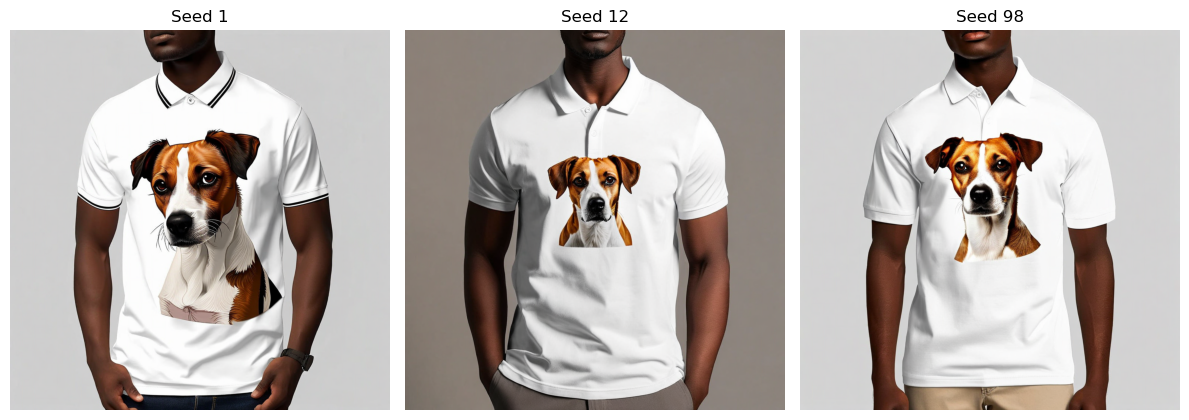

In [9]:
generated_images = []

# Generate image using only a text prompt.
for index, seed in enumerate(seed_values):
    body = json.dumps(
        {
            "taskType": "TEXT_IMAGE",
            "textToImageParams": {"text": text},
            "imageGenerationConfig": {
                "numberOfImages": 1,  # Number of images to generate, up to 5
                "width": 1024,
                "height": 1024,
                "cfgScale": 6.5,  # How closely the prompt will be followed
                "seed": seed,  # Any number from 0 through 858,993,459
                "quality": "premium",  # Quality of either "standard" or "premium"
            },
        }
    )

    print(f"Generating image {index + 1} of {len(seed_values)}...")

    response = bedrock_runtime_client.invoke_model(
        body=body,
        modelId=image_generation_model_id,
        accept="application/json",
        contentType="application/json",
    )

    response_body = json.loads(response.get("body").read())

    base64_images = response_body.get("images")
    image_path = f"{output_dir}/01-text-to-image_seed-{seed}.png"
    save_image(base64_images[0], image_path)

    print(f"Saved to {image_path}")

    generated_img = [
        Image.open(io.BytesIO(base64.b64decode(base64_image)))
        for base64_image in base64_images
    ]
    generated_images.append(generated_img[0])
    time.sleep(2)  # Wait for 2 seconds between requests

# Plot comparison images
plot_images_for_comparison(
    generated_images=generated_images,
    labels=seed_values,
    prompt=text,
    comparison_mode=True,
    title_prefix="Seed",
)

<div class="alert alert-block alert-info">
<strong>💡 Bonus Activity:</strong> Try different seeds to generate a different set of variations. Try a different prompt to make more drastic changes.
</div>


#### Example 2: Exploring resolution and aspect ratio

You can change the image aspect ratio by providing different height and width values. For example, 1024x1024 indicates an aspect ratio of 1:1, while 1280x720 indicates an aspect ratio of 16:9.

Nova Canvas supports a wide range of resolutions and aspect ratios. You may use any width and height as long as the resulting resolution adheres to all of the following:

- Each side's length is no shorter than 320 and no longer than 4096
- Each side's length is evenly divisible by 16
- The aspect ratio ranges from 1:4 (portrait) through 4:1 (landscape)
- The total number of pixels (width x height) does not exceed 4,194,304 (the equivalent of 2048 x 2048)

Let's see how different aspect ratios affect the composition of an image. Run the cells below. The generated images will be saved to the "output" folder.


In [12]:
# Define the main input parameters.
text = "A men's collared white t-shirt, with a dog in the center; the whole shirt is visible; Men's skin color must be different."
ratio_values = [(1024, 1024), (1280, 720), (672, 1024)]
seed = 12

Generating image 1 of 3...
Saved to output/01-text-to-image_resolution-1024x1024.png
Generating image 2 of 3...
Saved to output/01-text-to-image_resolution-1280x720.png
Generating image 3 of 3...
Saved to output/01-text-to-image_resolution-672x1024.png
Prompt: A collared white t-shirt with a dog image in the center, the T-shirt is displayed on a headless white mannequin in an skate shop



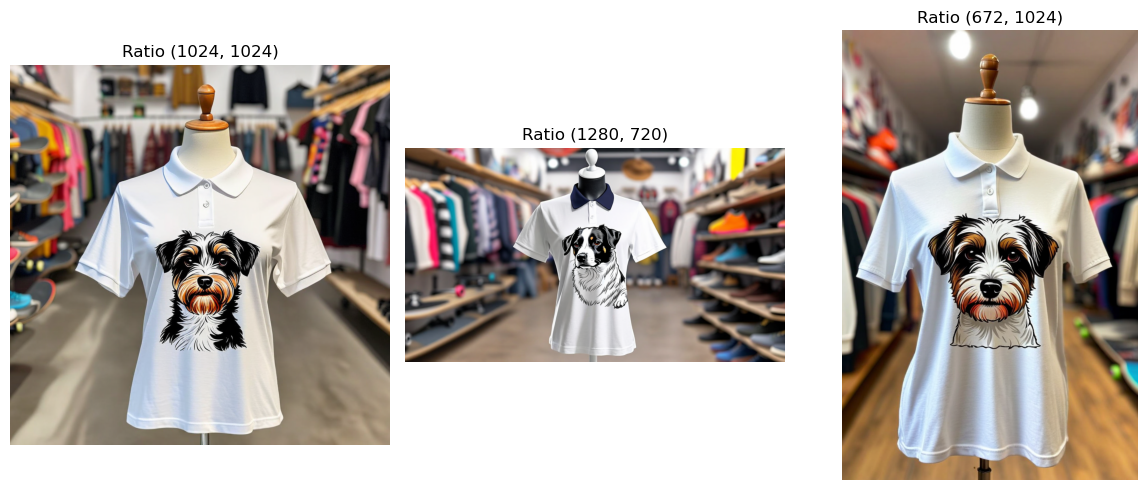

In [21]:
generated_images = []

# Generate image using only a text prompt.
for index, ratio in enumerate(ratio_values):
    body = json.dumps(
        {
            "taskType": "TEXT_IMAGE",
            "textToImageParams": {"text": text},  # A description of what to generate
            "imageGenerationConfig": {
                "numberOfImages": 1,  # Number of images to generate, up to 5.
                "width": ratio[0],
                "height": ratio[1],
                "cfgScale": 6.5,  # How closely the prompt will be followed
                "seed": seed,  # Any number from 0 through 858,993,459
                "quality": "standard",  # Either "standard" or "premium".
            },
        }
    )

    print(f"Generating image {index + 1} of {len(ratio_values)}...")

    response = bedrock_runtime_client.invoke_model(
        body=body,
        modelId=image_generation_model_id,
        accept="application/json",
        contentType="application/json",
    )

    response_body = json.loads(response.get("body").read())

    base64_images = response_body.get("images")
    image_path = f"{output_dir}/01-text-to-image_resolution-{ratio[0]}x{ratio[1]}.png"
    save_image(base64_images[0], image_path)

    print(f"Saved to {image_path}")

    generated_img = [
        Image.open(io.BytesIO(base64.b64decode(base64_image)))
        for base64_image in base64_images
    ]
    generated_images.append(generated_img[0])
    time.sleep(2)  # Wait for 2 seconds between requests

# Plot comparison images
plot_images_for_comparison(
    generated_images=generated_images,
    labels=ratio_values,
    prompt=text,
    comparison_mode=True,
    title_prefix="Ratio",
)

<div class="alert alert-block alert-info">
<strong>💡 Bonus Activity:</strong> Try different seeds and different resolutions to see their effect.
</div>


#### Example 3: Exploring the "cfgScale" parameter

The `cfgScale` parameter controls how closely your prompt will be followed. In this example, we are going to generate images using different values for `cfgScale` to see their effect.

`cfgScale` may be set to min 1.1 up to a max of 10. Lower values give the model more freedom to interpret your prompt loosely. Higher values are more faithful to your prompt, but setting the value too high can result in over-emphasis of some things mentioned in your prompt. The default is 6.5 and is a good starting point.

Run the cells below. The generated images will be saved to the "output" folder. Note how a value of 10 (the maximum) results in over-emphasis of the "skate shop" part of the prompt, adding wheels to everything!


In [24]:
# Define the main input parameters.
text = "A collared white t-shirt with a dog image in the center, the T-shirt is displayed on a headless white mannequin in an skate shop"
cfg_scale = [1.1, 6.5]
seed = 42

Generating image 1 of 2...
Saved to output/01-text-to-image_cfgScale-1.1.png
Generating image 2 of 2...
Saved to output/01-text-to-image_cfgScale-6.5.png
Prompt: A collared white t-shirt with a dog image in the center, the T-shirt is displayed on a headless white mannequin in an skate shop



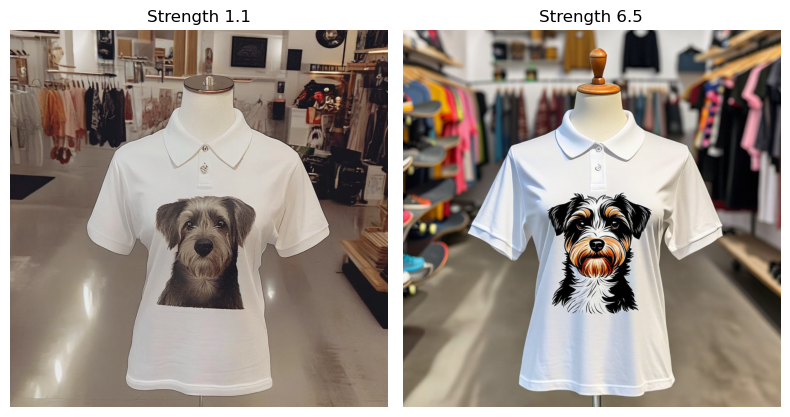

In [25]:
generated_images = []

# Generate image without reference
for index, cfg in enumerate(cfg_scale):
    body = json.dumps(
        {
            "taskType": "TEXT_IMAGE",
            "textToImageParams": {"text": text},
            "imageGenerationConfig": {
                "numberOfImages": 1,  # Number of images to generate, up to 5.
                "width": 1024,
                "height": 1024,
                "cfgScale": cfg,  # How closely the prompt will be followed
                "seed": seed,  # Any number from 0 through 858,993,459
                "quality": "standard",  # Either "standard" or "premium".
            },
        }
    )

    print(f"Generating image {index + 1} of {len(cfg_scale)}...")

    response = bedrock_runtime_client.invoke_model(
        body=body,
        modelId=image_generation_model_id,
        accept="application/json",
        contentType="application/json",
    )

    response_body = json.loads(response.get("body").read())

    base64_images = response_body.get("images")
    image_path = f"{output_dir}/01-text-to-image_cfgScale-{cfg}.png"
    save_image(base64_images[0], image_path)

    print(f"Saved to {image_path}")

    generated_img = [
        Image.open(io.BytesIO(base64.b64decode(base64_image)))
        for base64_image in base64_images
    ]
    generated_images.append(generated_img[0])
    time.sleep(2)  # Wait for 2 seconds between requests

# Plot comparison images
plot_images_for_comparison(
    generated_images=generated_images,
    labels=cfg_scale,
    prompt=text,
    comparison_mode=True,
    title_prefix="Strength",
)

## Take Away

Text-to-image generation is a powerful feature that empowers users to create visual content from textual descriptions. By simply writing descriptive text prompts, individuals can generate unique and diverse images that match their vision. This innovative tool has wide-ranging applications, from conceptual art and storyboarding to rapid prototyping and visual brainstorming. Whether you're an artist seeking inspiration, a marketer creating promotional materials, or a game developer designing characters, the text-to-image feature of Nova Canvas offers an efficient and accessible way to bring ideas to life visually.
